In [69]:
# Load necessary libraries
library(dplyr)
library(ggplot2)
library(tidyr)
library(summarytools)
library(mice)
library(factoextra)

In [70]:
# Load the Excel file
data <- read.csv("vehicles.csv")
print(data)

    compactness circularity distance_circularity radius_ratio
1            95          48                   83          178
2            91          41                   84          141
3           104          50                  106          209
4            93          41                   82          159
5            85          44                   70          205
6           107          NA                  106          172
7            97          43                   73          173
8            90          43                   66          157
9            86          34                   62          140
10           93          44                   98           NA
11           86          36                   70          143
12           90          34                   66          136
13           88          46                   74          171
14           89          42                   85          144
15           94          49                   79          203
16      

In [71]:
# View basic structure and summary
str(data)
summary(data)

'data.frame':	846 obs. of  19 variables:
 $ compactness                : int  95 91 104 93 85 107 97 90 86 93 ...
 $ circularity                : int  48 41 50 41 44 NA 43 43 34 44 ...
 $ distance_circularity       : int  83 84 106 82 70 106 73 66 62 98 ...
 $ radius_ratio               : int  178 141 209 159 205 172 173 157 140 NA ...
 $ pr.axis_aspect_ratio       : int  72 57 66 63 103 50 65 65 61 62 ...
 $ max.length_aspect_ratio    : int  10 9 10 9 52 6 6 9 7 11 ...
 $ scatter_ratio              : int  162 149 207 144 149 255 153 137 122 183 ...
 $ elongatedness              : int  42 45 32 46 45 26 42 48 54 36 ...
 $ pr.axis_rectangularity     : int  20 19 23 19 19 28 19 18 17 22 ...
 $ max.length_rectangularity  : int  159 143 158 143 144 169 143 146 127 146 ...
 $ scaled_variance            : int  176 170 223 160 241 280 176 162 141 202 ...
 $ scaled_variance.1          : int  379 330 635 309 325 957 361 281 223 505 ...
 $ scaled_radius_of_gyration  : int  184 158 220 127 188 26

  compactness      circularity    distance_circularity  radius_ratio  
 Min.   : 73.00   Min.   :33.00   Min.   : 40.00       Min.   :104.0  
 1st Qu.: 87.00   1st Qu.:40.00   1st Qu.: 70.00       1st Qu.:141.0  
 Median : 93.00   Median :44.00   Median : 80.00       Median :167.0  
 Mean   : 93.68   Mean   :44.83   Mean   : 82.11       Mean   :168.9  
 3rd Qu.:100.00   3rd Qu.:49.00   3rd Qu.: 98.00       3rd Qu.:195.0  
 Max.   :119.00   Max.   :59.00   Max.   :112.00       Max.   :333.0  
                  NA's   :5       NA's   :4            NA's   :6      
 pr.axis_aspect_ratio max.length_aspect_ratio scatter_ratio   elongatedness  
 Min.   : 47.00       Min.   : 2.000          Min.   :112.0   Min.   :26.00  
 1st Qu.: 57.00       1st Qu.: 7.000          1st Qu.:147.0   1st Qu.:33.00  
 Median : 61.00       Median : 8.000          Median :157.0   Median :43.00  
 Mean   : 61.68       Mean   : 8.567          Mean   :168.9   Mean   :40.93  
 3rd Qu.: 65.00       3rd Qu.:10.000      

In [72]:
# Check for missing values
missing_data <- sapply(data, function(x) sum(is.na(x)))
print(missing_data)

                compactness                 circularity 
                          0                           5 
       distance_circularity                radius_ratio 
                          4                           6 
       pr.axis_aspect_ratio     max.length_aspect_ratio 
                          2                           0 
              scatter_ratio               elongatedness 
                          1                           1 
     pr.axis_rectangularity   max.length_rectangularity 
                          3                           0 
            scaled_variance           scaled_variance.1 
                          3                           2 
  scaled_radius_of_gyration scaled_radius_of_gyration.1 
                          2                           4 
             skewness_about            skewness_about.1 
                          6                           1 
           skewness_about.2               hollows_ratio 
                          1    

In [73]:
data <- data %>%
  mutate(across(where(is.numeric), ~ ifelse(is.na(.), mean(as.numeric(.), na.rm = TRUE), .)))

In [74]:
missing_data <- sapply(data, function(x) sum(is.na(x)))
print(missing_data)

                compactness                 circularity 
                          0                           0 
       distance_circularity                radius_ratio 
                          0                           0 
       pr.axis_aspect_ratio     max.length_aspect_ratio 
                          0                           0 
              scatter_ratio               elongatedness 
                          0                           0 
     pr.axis_rectangularity   max.length_rectangularity 
                          0                           0 
            scaled_variance           scaled_variance.1 
                          0                           0 
  scaled_radius_of_gyration scaled_radius_of_gyration.1 
                          0                           0 
             skewness_about            skewness_about.1 
                          0                           0 
           skewness_about.2               hollows_ratio 
                          0    

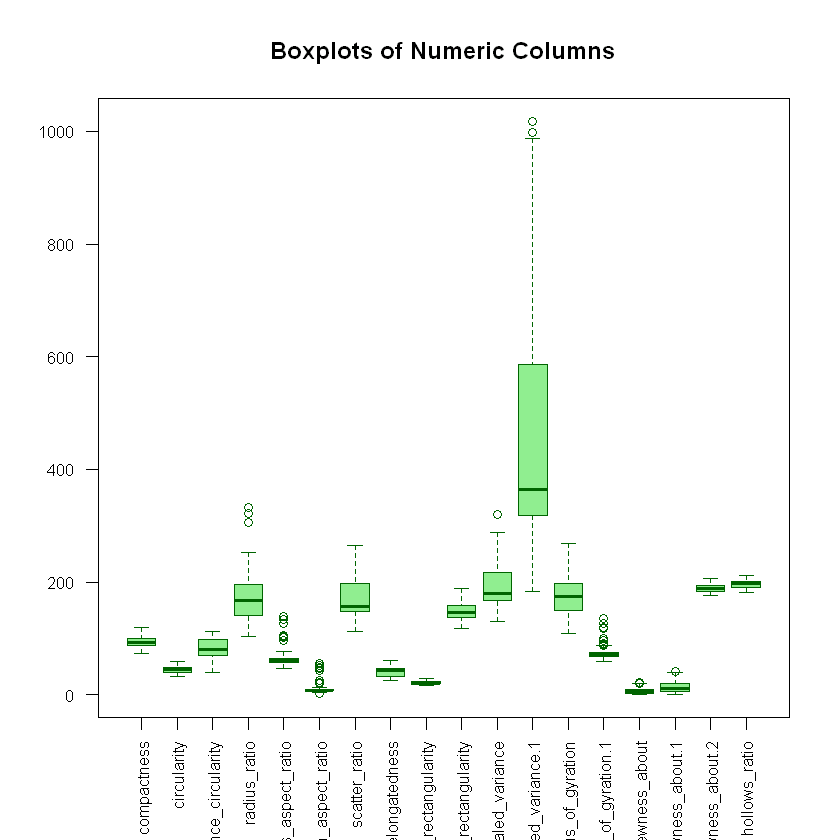

In [75]:
# Subset numeric columns
numeric_data <- data[, sapply(data, is.numeric)]

# Plot all boxplots together
boxplot(numeric_data, 
        main = "Boxplots of Numeric Columns", 
        las = 2,         # Rotate axis labels
        col = "lightgreen", 
        border = "darkgreen",
        cex.axis = 0.8)  # Adjust label size


In [76]:
# Function to cap outliers using IQR
treat_outliers <- function(x) {
  Q1 <- quantile(x, 0.25, na.rm = TRUE)
  Q3 <- quantile(x, 0.75, na.rm = TRUE)
  IQR <- Q3 - Q1
  lower <- Q1 - 1.5 * IQR
  upper <- Q3 + 1.5 * IQR
  x[x < lower] <- lower
  x[x > upper] <- upper
  return(x)
}

# Apply to numerical columns
numerical_cols <- data %>% select(where(is.numeric)) %>% names()
data <- data %>%
  mutate(across(all_of(numerical_cols), treat_outliers))

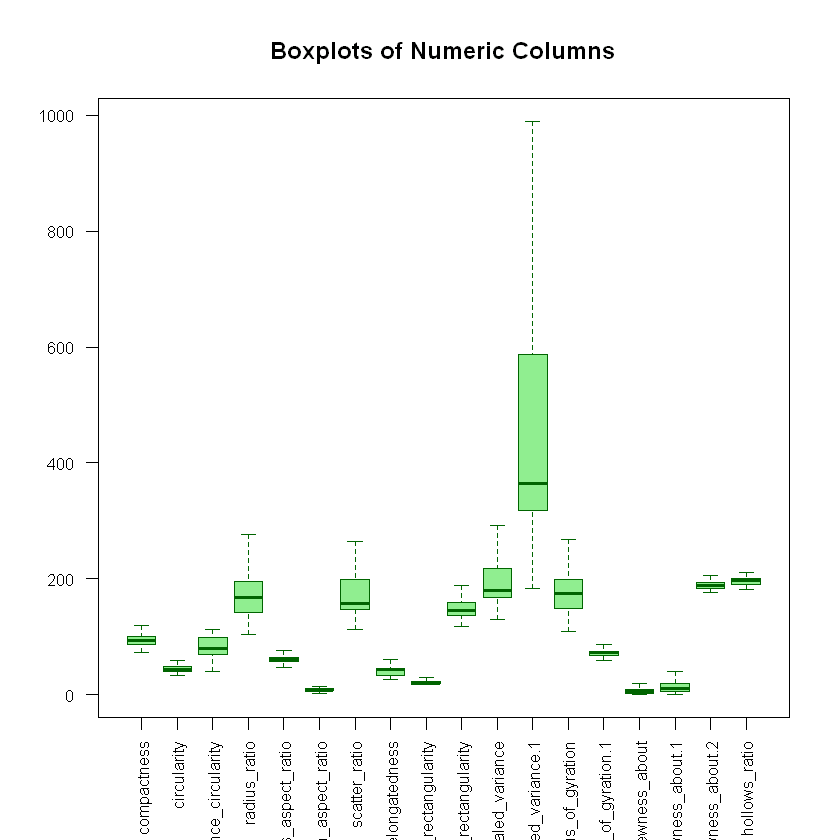

In [77]:
# Subset numeric columns
numeric_data <- data[, sapply(data, is.numeric)]

# Plot all boxplots together
boxplot(numeric_data, 
        main = "Boxplots of Numeric Columns", 
        las = 2,         # Rotate axis labels
        col = "lightgreen", 
        border = "darkgreen",
        cex.axis = 0.8)  # Adjust label size


In [78]:
# Standardize numerical features
scaled_data <- data %>%
  select(all_of(numerical_cols)) %>%
  scale()  # Z-score normalization (mean=0, sd=1)


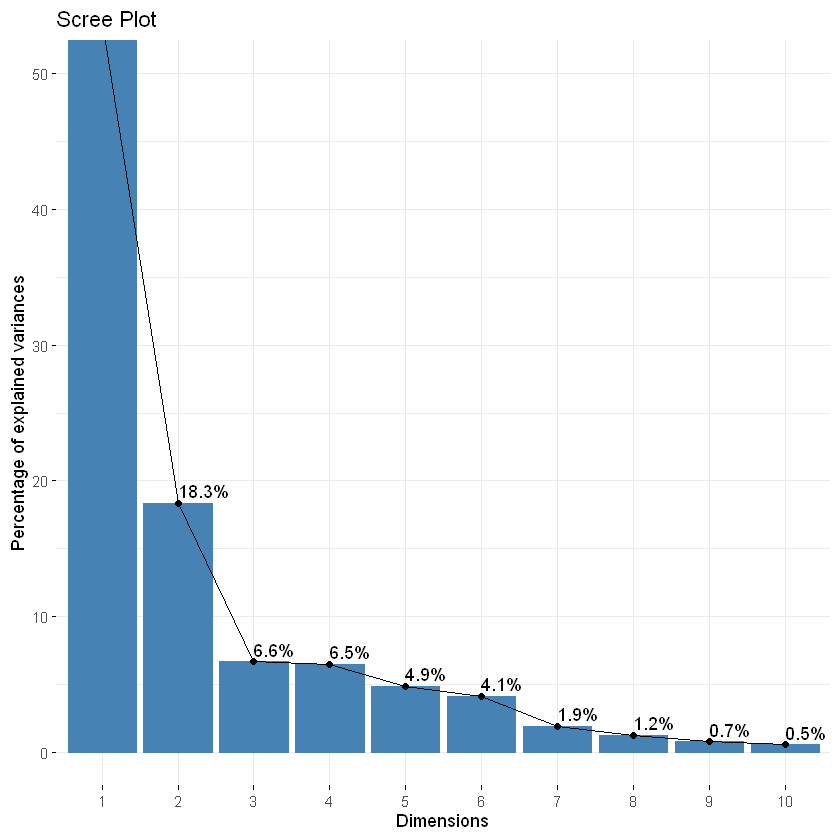

In [79]:
# Perform PCA
pca <- prcomp(scaled_data, center = TRUE, scale. = FALSE)  # Already scaled

# Scree plot to decide components
fviz_eig(pca, addlabels = TRUE, ylim = c(0, 50)) +
  labs(title = "Scree Plot")

# Choose optimal components (e.g., 95% variance)
cum_var <- cumsum(pca$sdev^2 / sum(pca$sdev^2))
optimal_components <- which(cum_var >= 0.95)[1]
pca_reduced <- pca$x[, 1:optimal_components]

PC1,PC2,PC3
-0.53315208,0.6187050,0.72991187
1.53156985,0.3832814,-0.01902658
-3.86861540,-0.1983950,1.11022338
1.57746111,3.0050873,0.34103790
-0.04787387,-1.7304226,1.47657569


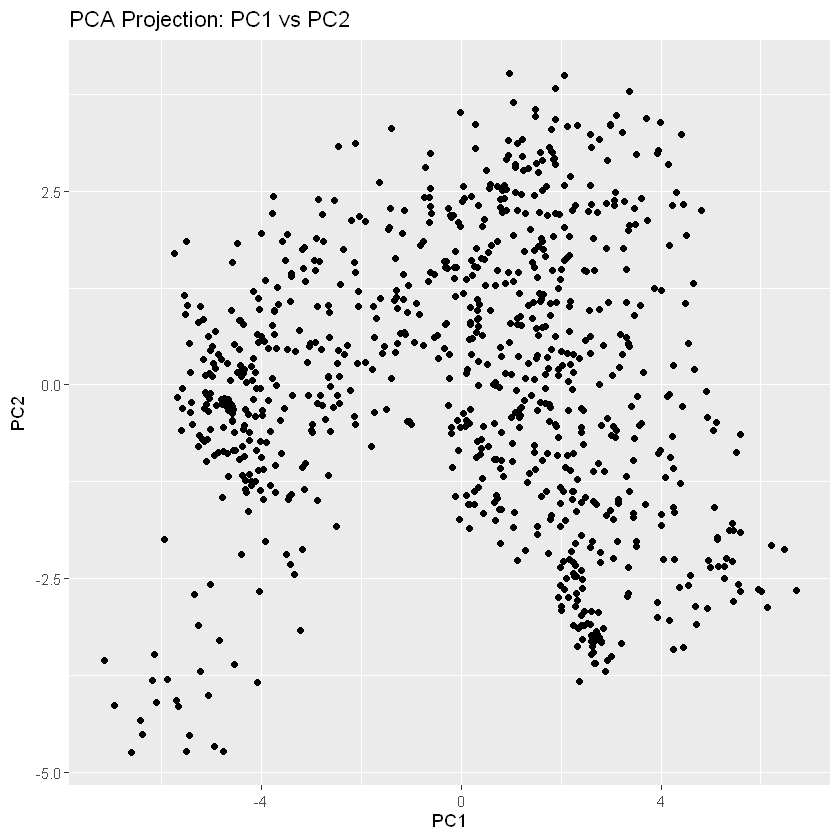

In [80]:
# Extract PC values
pc_scores <- pca$x           # Projected data (samples x PCs)
loadings <- pca$rotation      # Variable loadings (features x PCs)
variance <- pca$sdev^2        # Variance explained by each PC

# View first 5 samples and 3 PCs
head(pc_scores[, 1:3], 5)

# Plot PC1 vs PC2
library(ggplot2)
ggplot(as.data.frame(pc_scores), aes(PC1, PC2)) +
  geom_point() +
  labs(title = "PCA Projection: PC1 vs PC2")

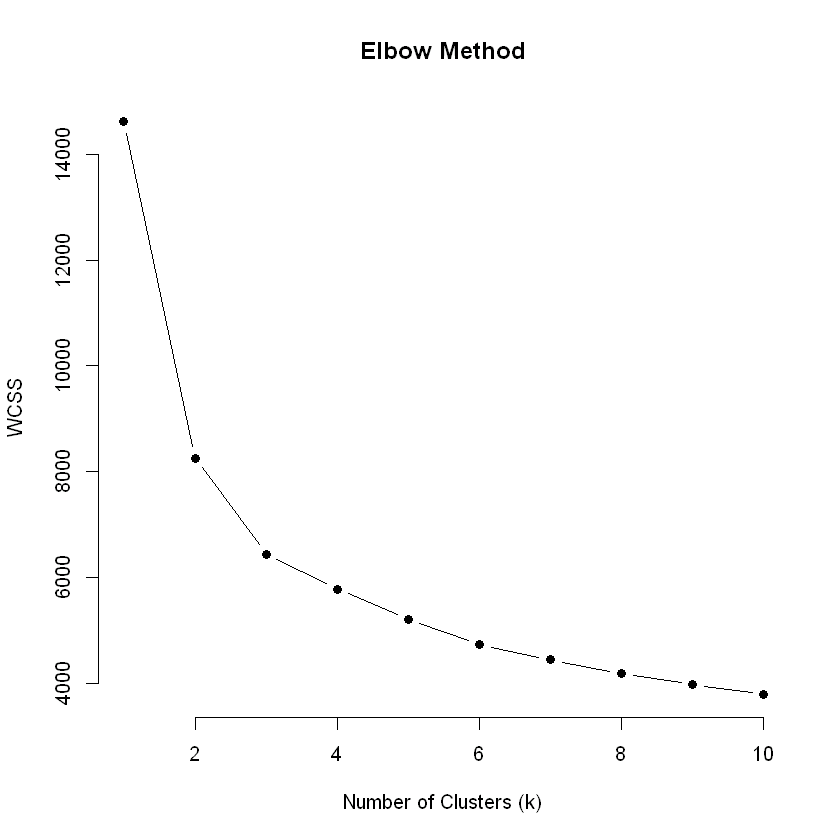

In [81]:
library(purrr)  # Provides map_dbl() function 

# Calculate WCSS for different k
wcss <- map_dbl(1:10, ~{
  kmeans(pca_reduced, centers = ., nstart = 10)$tot.withinss
})

# Plot Elbow Method
plot(1:10, wcss, type = "b", pch = 19, frame = FALSE,
     xlab = "Number of Clusters (k)", ylab = "WCSS",
     main = "Elbow Method")

  cluster size ave.sil.width
1       1  266          0.58
2       2  237          0.44
3       3  343          0.39


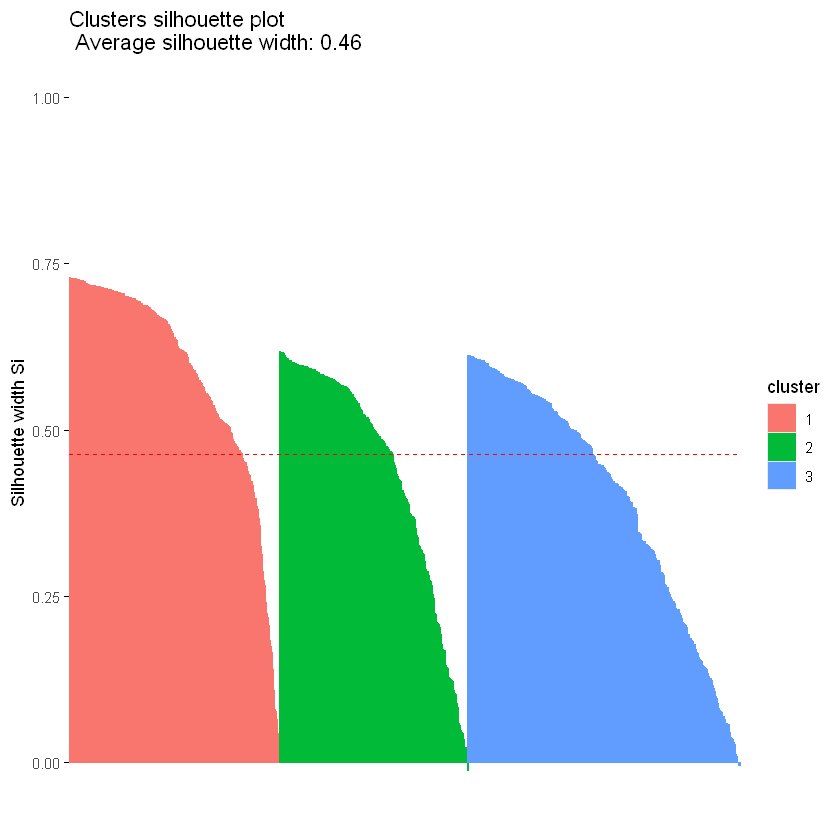

In [82]:
library(cluster)

# Use first 2 principal components (PC1 and PC2)
pca_data <- as.data.frame(pca$x[, 1:2])

# Perform k-means clustering
set.seed(123)  # for reproducibility
km_res <- kmeans(pca_data, centers = 3, nstart = 25)

# Compute silhouette
sil <- silhouette(km_res$cluster, dist(pca_data))

# Plot silhouette
fviz_silhouette(sil)


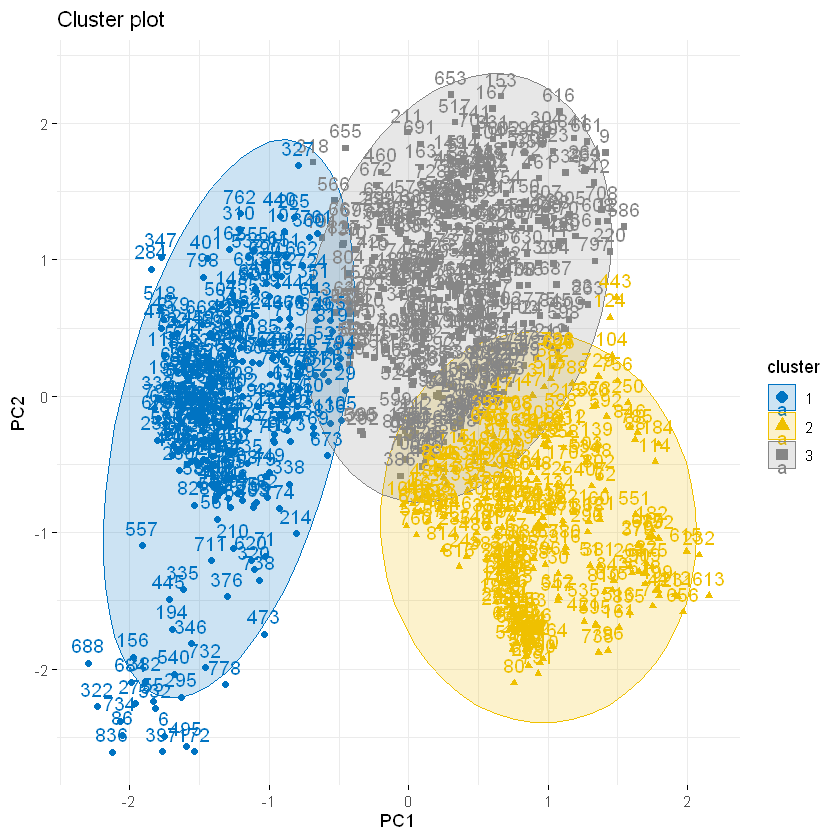

In [83]:
# Perform K-Means clustering with 3 clusters
set.seed(123)
kmeans_result <- kmeans(pca_data, centers = 3, nstart = 25)

# Add cluster assignments to your data
pca_data$cluster <- as.factor(kmeans_result$cluster)

# Plot clusters in PCA space
fviz_cluster(kmeans_result, data = pca_data[, 1:2],
             ellipse.type = "norm",
             palette = "jco",
             ggtheme = theme_minimal())

In [84]:
loadings <- pca$rotation
head(loadings)

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15,PC16,PC17,PC18
compactness,-0.27252834,0.09260509,-0.01181848,-0.20008443,0.16522159,0.11900165,-0.30046627,0.73077637,0.33677773,-0.24433558,0.03983410,-0.11698228,-0.09916490,-0.08766794,-0.07175563,0.008928424,0.006002589,-0.005550181
circularity,-0.28865258,-0.12975553,0.20525905,-0.01162554,-0.11514155,0.05333461,0.39778568,0.10544673,0.04724725,0.05933323,0.04377631,0.25910509,-0.06836415,-0.24813666,0.26909379,0.671509110,0.087950657,0.000929227
distance_circularity,-0.30257251,0.05119754,-0.09129229,-0.06838425,-0.10538062,0.02682068,-0.09490579,-0.33973741,0.25173709,-0.14418392,0.77078395,-0.14326921,0.12339747,0.15771800,0.13128748,0.015501323,-0.009937260,0.009647565
radius_ratio,-0.26778608,0.19470893,0.03015799,0.28236584,0.10537444,-0.21796087,-0.16462885,-0.04467820,-0.05983369,-0.24807386,-0.05829201,0.51130936,0.23247454,-0.33379332,0.33238377,-0.335234387,-0.052330626,-0.031806910
pr.axis_aspect_ratio,-0.09597903,0.24235401,0.24559535,0.61035134,0.08348336,-0.49780978,0.05975679,0.09519904,0.24869069,0.17548568,0.01417254,-0.22062392,-0.08908957,0.20617116,-0.15534832,0.122964569,0.016450843,0.017417669
max.length_aspect_ratio,-0.18368636,0.10242874,0.14208314,-0.04570211,-0.78632339,-0.10618908,-0.39355433,0.01390635,-0.19798013,-0.05843132,-0.19851243,-0.09518512,-0.15540957,0.12428537,0.12063165,0.054415911,-0.020648601,-0.014703558


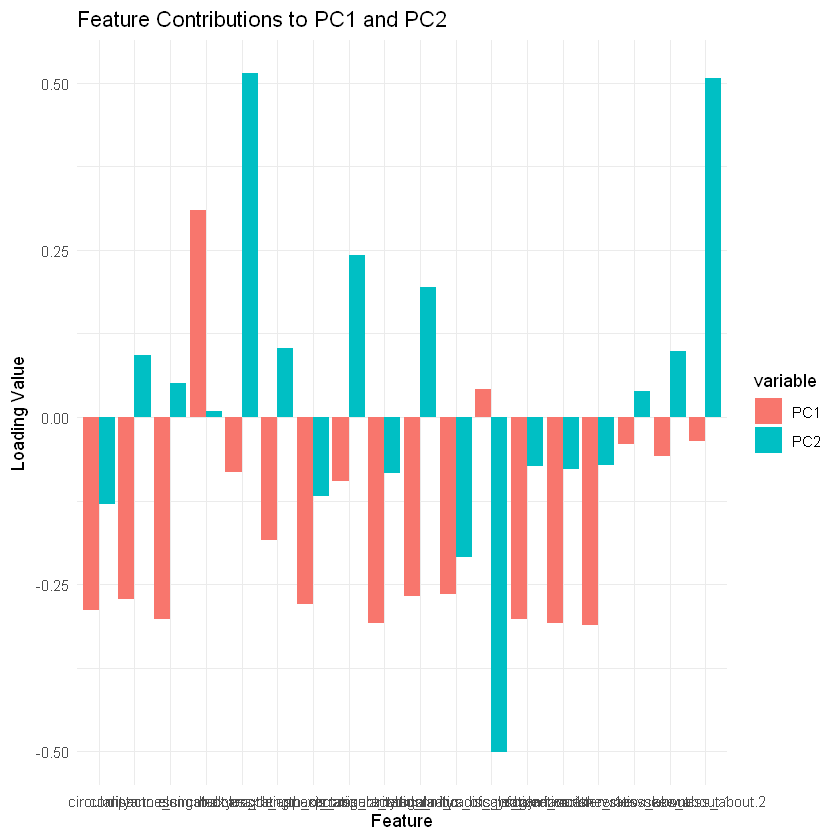

In [85]:
# Convert to dataframe for plotting
loadings_df <- as.data.frame(loadings[, 1:2])
loadings_df$feature <- rownames(loadings_df)

# Melt for ggplot
library(reshape2)
loadings_melted <- melt(loadings_df, id.vars = "feature")

# Bar plot
ggplot(loadings_melted, aes(x = feature, y = value, fill = variable)) +
  geom_bar(stat = "identity", position = "dodge") +
  labs(title = "Feature Contributions to PC1 and PC2",
       y = "Loading Value", x = "Feature") +
  theme_minimal()

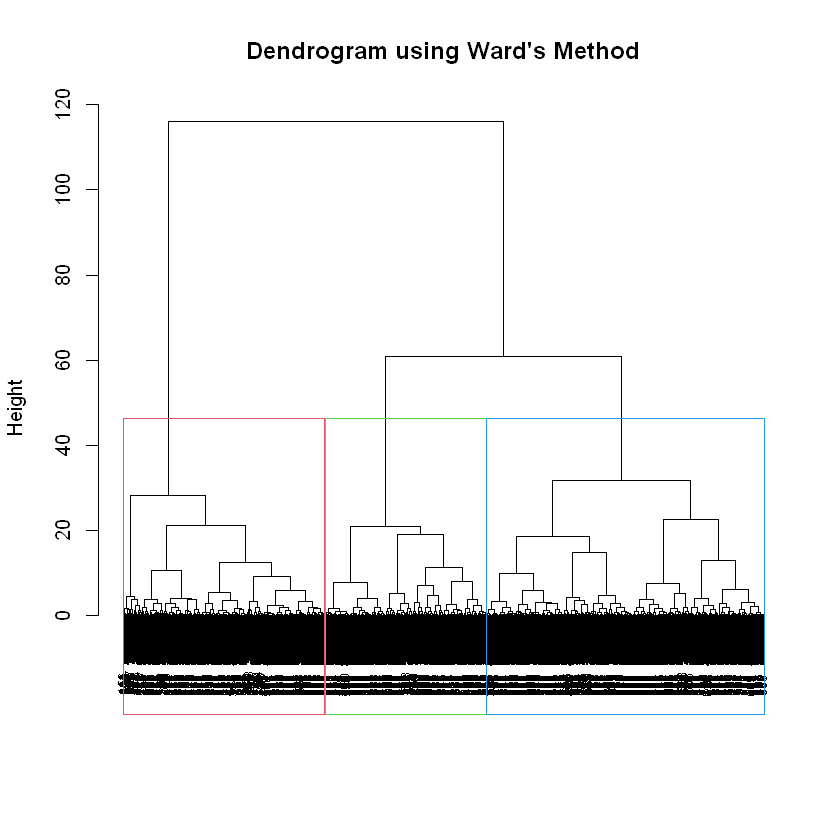

In [86]:
# Compute distance matrix on PCA-reduced data
dist_matrix <- dist(pca_data)

# Apply hierarchical clustering (Ward's method is common for compact clusters)
hc <- hclust(dist_matrix, method = "ward.D2")

# Plot the dendrogram
plot(hc, main = "Dendrogram using Ward's Method", xlab = "", sub = "", cex = 0.6)

# Add rectangles to show cluster groups (choose 3 based on dendrogram cut)
rect.hclust(hc, k = 3, border = 2:4)


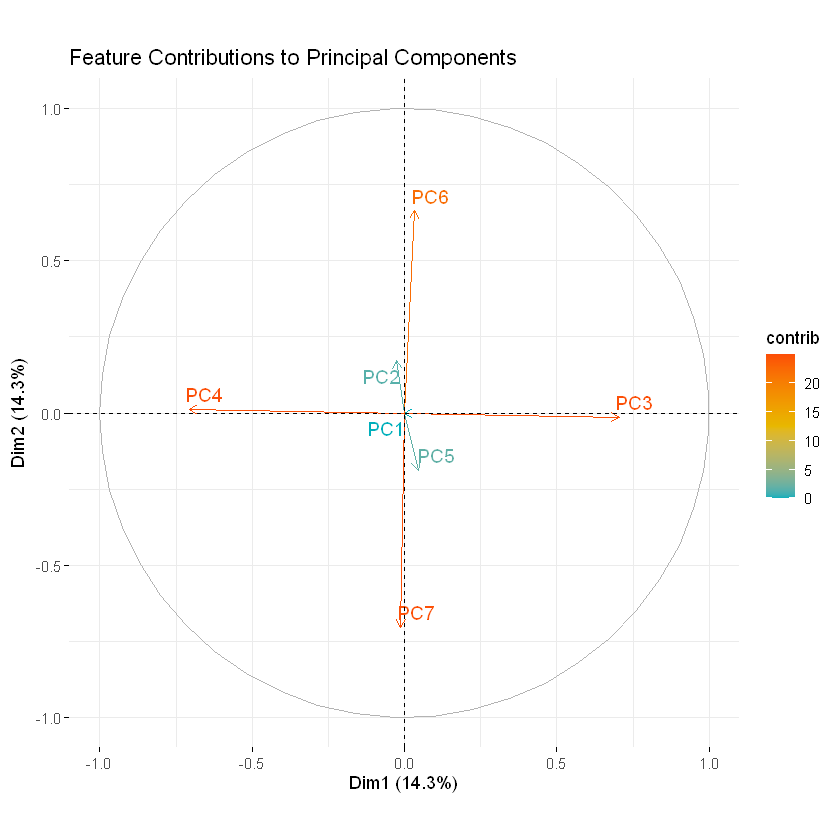

In [89]:
pca_result <- prcomp(pca_reduced, scale. = TRUE)
fviz_pca_var(pca_result,
             col.var = "contrib",
             gradient.cols = c("#00AFBB", "#E7B800", "#FC4E07"),
             repel = TRUE,
             title = "Feature Contributions to Principal Components")
